In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
hrattr_data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(hrattr_data.head(5))
print(hrattr_data.shape)

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

           ...           RelationshipSatisfaction StandardHours  \
0      

In [3]:
hrattr_data['Attrition_ind'] = 0
hrattr_data.loc[hrattr_data['Attrition'] == 'Yes', 'Attrition_ind'] = 1

In [4]:
dummy_busnstrvl = pd.get_dummies(hrattr_data['BusinessTravel'],prefix='busns_trvl')
dummy_dept = pd.get_dummies(hrattr_data['Department'], prefix='dept')
dummy_edufield = pd.get_dummies(hrattr_data['EducationField'],prefix='edufield')
dummy_gender = pd.get_dummies(hrattr_data['Gender'], prefix='gend')
dummy_jobrole = pd.get_dummies(hrattr_data['JobRole'],prefix='jobrole')
dummy_maritstat = pd.get_dummies(hrattr_data['MaritalStatus'],prefix='maritalstat')
dummy_overtime = pd.get_dummies(hrattr_data['OverTime'],prefix='overtime')

In [5]:
continuous_columns = ['Age','DailyRate','DistanceFromHome','Education',
'EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel','JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
'NumCompaniesWorked','PercentSalaryHike', 'PerformanceRating',
'RelationshipSatisfaction','StockOptionLevel', 'TotalWorkingYears',
'TrainingTimesLastYear','WorkLifeBalance', 'YearsAtCompany',
'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager']

In [6]:
hrattr_continuous = hrattr_data[continuous_columns]

In [7]:
hrattr_data_new = pd.concat([dummy_busnstrvl, dummy_dept,
dummy_edufield, dummy_gender, dummy_jobrole, dummy_maritstat,
dummy_overtime, hrattr_continuous, hrattr_data['Attrition_ind']],axis=1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(hrattr_data_new.drop(['Attrition_ind'], axis = 1), hrattr_data_new['Attrition_ind'], train_size = 0.7, random_state = 42)

# #Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
dt_fit = DecisionTreeClassifier(criterion='gini', max_depth = 5, min_samples_split = 2, min_samples_leaf=1, random_state=42)
dt_fit.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [10]:
print("\n Decision Tree - Train Confusion Matrix\n\n", pd.crosstab(y_train, dt_fit.predict(x_train), rownames=["Actual"], colnames = ["Predicted"]))
print ("\nDecision Tree - Train accuracy\n\n",round(accuracy_score(y_train, dt_fit.predict(x_train)),3))


 Decision Tree - Train Confusion Matrix

 Predicted    0   1
Actual            
0          844   9
1           98  78

Decision Tree - Train accuracy

 0.896


In [11]:
print ("\n\nDecision Tree - Test ConfusionMatrix\n\n",pd.crosstab(y_test, dt_fit.predict(x_test),rownames =["Actuall"],colnames = ["Predicted"]))
print ("\nDecision Tree - Test accuracy",round(accuracy_score(y_test,dt_fit.predict(x_test)),3))



Decision Tree - Test ConfusionMatrix

 Predicted    0   1
Actuall           
0          361  19
1           49  12

Decision Tree - Test accuracy 0.846


In [12]:
print ("\nDecision Tree - Test Classification Report\n",classification_report( y_test, dt_fit.predict(x_test)))


Decision Tree - Test Classification Report
              precision    recall  f1-score   support

          0       0.88      0.95      0.91       380
          1       0.39      0.20      0.26        61

avg / total       0.81      0.85      0.82       441



By carefully observing the results, we can infer that, even though the test accuracy is high(84.6%), the precision and recall of one category (Attrition = Yes) is low (precision = 0.39 andrecall = 0.20). This could be a serious issue when management tries to use this model to provide some extra benefits proactively to the employees with a high chance of attrition prior to actual attrition, as this model is unable to identify the real employees who will be leaving. Hence, we need to look for other modifications; one way is to control the model by using class weights. By utilizing class weights, we can increase the importance of a particular class at the cost of an increase in other errors.

For example, by increasing class weight to category 1, we can identify more employees with the characteristics of actual attrition, but by doing so, we will mark some of the nonpotential churner employees as potential attriters (which should be acceptable).

Another classical example of the important use of class weights is, in banking scenarios. When giving loans, it is better to reject some good applications than accepting bad loans. Hence, even in this case, it is a better idea to use higher weightage to defaulters over nondefaulters.

# #Tuning class weights in decision tree classifier

In the following code, class weights are tuned to see the performance change in decision trees with the same parameters. A dummy DataFrame is created to save all the results of various precision-recall details of combinations:

In [13]:
dummyarray = np.empty((6,10))
dt_wttune = pd.DataFrame(dummyarray)

In [14]:
dt_wttune.columns = ["zero_wght","one_wght","tr_accuracy","tst_accuracy", "prec_zero","prec_one", "prec_ovll",
      "recl_zero","recl_one","recl_ovll"]

In [15]:
##Weights for the zero category are verified from 0.01 to 0.5, as we know we do not want to
##explore cases where the zero category will be given higher weightage than one category
zero_clwghts = [0.01,0.1,0.2,0.3,0.4,0.5]

In [16]:
for i in range(len(zero_clwghts)):
    clwght = {0:zero_clwghts[i],1:1.0-zero_clwghts[i]}
    dt_fit = DecisionTreeClassifier(criterion="gini", max_depth=5,min_samples_split=2, min_samples_leaf=1,random_state=42,class_weight =clwght)
    dt_fit.fit(x_train,y_train)
    dt_wttune.loc[i, 'zero_wght'] = clwght[0]
    dt_wttune.loc[i, 'one_wght'] = clwght[1]
    dt_wttune.loc[i, 'tr_accuracy'] = round(accuracy_score(y_train,dt_fit.predict( x_train)),3)
    dt_wttune.loc[i, 'tst_accuracy'] = round(accuracy_score(y_test,dt_fit.predict( x_test)),3)
    clf_sp = classification_report(y_test,dt_fit.predict(x_test)).split()
    dt_wttune.loc[i, 'prec_zero'] = float(clf_sp[5])
    dt_wttune.loc[i, 'prec_one'] = float(clf_sp[10])
    dt_wttune.loc[i, 'prec_ovll'] = float(clf_sp[17])
    dt_wttune.loc[i, 'recl_zero'] = float(clf_sp[6])
    dt_wttune.loc[i, 'recl_one'] = float(clf_sp[11])
    dt_wttune.loc[i, 'recl_ovll'] = float(clf_sp[18])
    print ("\nClass Weights",clwght,"Train accuracy:",round(accuracy_score( y_train,dt_fit.predict(x_train)),3),"Test accuracy:",round(accuracy_score(y_test, dt_fit.predict(x_test)),3))
    print ("Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict( x_test),rownames =["Actual"],colnames = ["Predicted"]))



Class Weights {0: 0.01, 1: 0.99} Train accuracy: 0.342 Test accuracy: 0.272
Test Confusion Matrix

 Predicted   0    1
Actual            
0          65  315
1           6   55

Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.806 Test accuracy: 0.732
Test Confusion Matrix

 Predicted    0   1
Actual            
0          282  98
1           20  41

Class Weights {0: 0.2, 1: 0.8} Train accuracy: 0.871 Test accuracy: 0.83
Test Confusion Matrix

 Predicted    0   1
Actual            
0          341  39
1           36  25

Class Weights {0: 0.3, 1: 0.7} Train accuracy: 0.881 Test accuracy: 0.839
Test Confusion Matrix

 Predicted    0   1
Actual            
0          345  35
1           36  25

Class Weights {0: 0.4, 1: 0.6} Train accuracy: 0.894 Test accuracy: 0.832
Test Confusion Matrix

 Predicted    0   1
Actual            
0          346  34
1           40  21

Class Weights {0: 0.5, 1: 0.5} Train accuracy: 0.896 Test accuracy: 0.846
Test Confusion Matrix

 Predicted    0   1
Actual

From the above results, we can seen that at class weight values of 0.3 (for zero) and
0.7 (for one) it is identifying a higher number of attriters (25 out of 61) without
compromising test accuracy 83.9% using decision trees methodology

# #Bagging classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier

In [18]:
dt_fit = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split =2, min_samples_leaf =1, 
                                random_state = 42, class_weight ={0:0.3, 1:0.7})

In [19]:
bag_fit = BaggingClassifier(base_estimator = dt_fit, n_estimators = 5000, max_samples = 0.67, max_features = 1.0, 
                            bootstrap = True, bootstrap_features = False, n_jobs = -1, random_state = 42 )

In [20]:
bag_fit.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.67, n_estimators=5000, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [21]:
print ("\nBagging - Train Confusion Matrix\n\n",pd.crosstab(y_train, bag_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))
print ("\nBagging- Train accuracy",round(accuracy_score(y_train,bag_fit.predict(x_train)),3))
print ("\nBagging - Train Classification Report\n",classification_report(y_train, bag_fit.predict(x_train)))
print ("\n\nBagging - Test Confusion Matrix\n\n",pd.crosstab(y_test,bag_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))
print ("\nBagging - Test accuracy",round(accuracy_score(y_test,bag_fit.predict(x_test)),3))
print ("\nBagging - Test Classification Report\n",classification_report(y_test, bag_fit.predict(x_test)))


Bagging - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          846    7
1           66  110

Bagging- Train accuracy 0.929

Bagging - Train Classification Report
              precision    recall  f1-score   support

          0       0.93      0.99      0.96       853
          1       0.94      0.62      0.75       176

avg / total       0.93      0.93      0.92      1029



Bagging - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          372   8
1           49  12

Bagging - Test accuracy 0.871

Bagging - Test Classification Report
              precision    recall  f1-score   support

          0       0.88      0.98      0.93       380
          1       0.60      0.20      0.30        61

avg / total       0.84      0.87      0.84       441



# #Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

The parameters used in random forest are: n_estimators representing the number of
individual decision trees used is 5000, maximum features selected are auto, which means it
will select sqrt(p) for classification and p/3 for regression automatically. Here is the
straightforward classification problem though. Minimum samples per leaf provides the
minimum number of observations required in the terminal node:

In [23]:
rf_fit = RandomForestClassifier(n_estimators = 5000, criterion= 'gini',max_depth = 5, min_samples_split = 2,
                                bootstrap= True, max_features = 'auto', min_samples_leaf = 1, class_weight= {0:0.3,1:0.7})

In [24]:
rf_fit.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.3, 1: 0.7},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
print("\nRandom Forest - Train Confusion Matrix\n\n",pd.crosstab(y_train, rf_fit.predict(x_train),rownames =
                                                                  ["Actuall"],colnames = ["Predicted"]))
print("\nRandom Forest - Train accuracy",round(accuracy_score(y_train,rf_fit.predict(x_train)),3))
print("\nRandom Forest - Train Classification Report\n",classification_report( y_train, rf_fit.predict(x_train)))
print("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab(y_test, rf_fit.predict(x_test),rownames =
                                                                  ["Actuall"],colnames = ["Predicted"]))
print("\nRandom Forest - Test accuracy",round(accuracy_score(y_test,rf_fit.predict(x_test)),3))
print("\nRandom Forest - Test Classification Report\n",classification_report( y_test, rf_fit.predict(x_test)))


Random Forest - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          842   11
1           74  102

Random Forest - Train accuracy 0.917

Random Forest - Train Classification Report
              precision    recall  f1-score   support

          0       0.92      0.99      0.95       853
          1       0.90      0.58      0.71       176

avg / total       0.92      0.92      0.91      1029



Random Forest - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          373   7
1           49  12

Random Forest - Test accuracy 0.873

Random Forest - Test Classification Report
              precision    recall  f1-score   support

          0       0.88      0.98      0.93       380
          1       0.63      0.20      0.30        61

avg / total       0.85      0.87      0.84       441



Random forest classifier produced 87.8% test accuracy compared with bagging 87.3%, and
also identifies 14 actually attrited employees in contrast with bagging, for which 13 attrited
employees have been identified:

# Plot of variable importance by mean decrease in gini

In [26]:
model_ranks = pd.Series(rf_fit.feature_importances_, index = x_train.columns, name = 'Importance').sort_values(ascending= False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:31].sort_values(ascending = True, inplace = False)

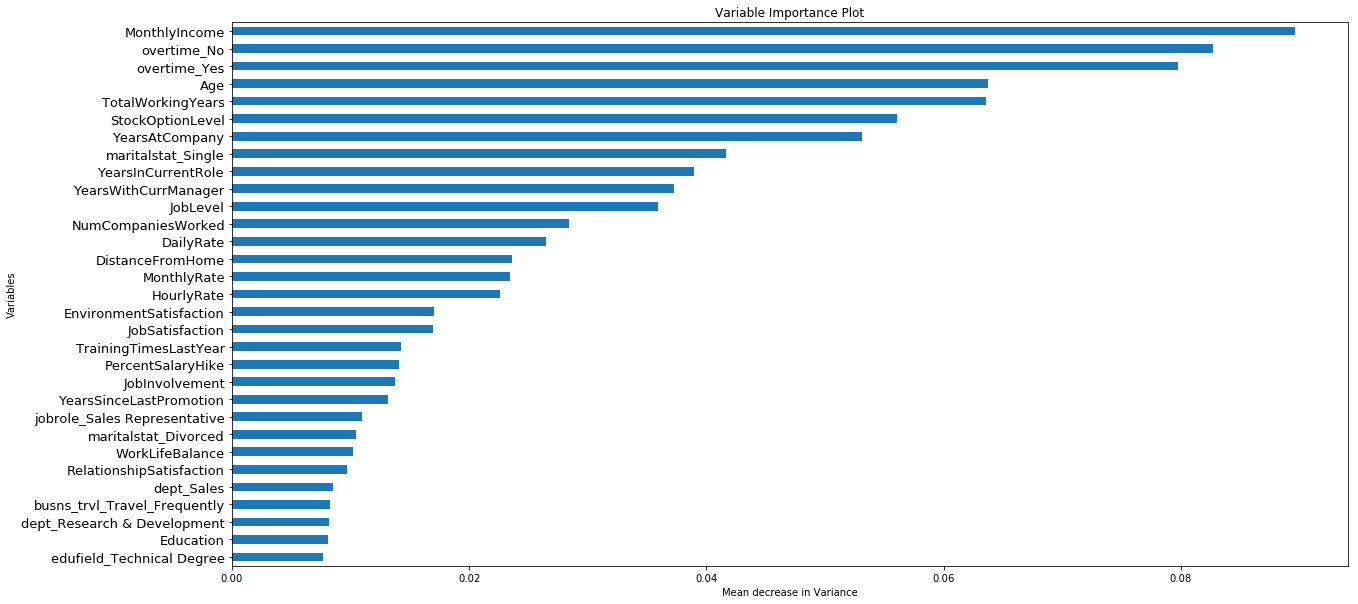

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
_ = ax.set_title("Variable Importance Plot")
_ = ax.set_xlabel('Mean decrease in Variance')
_ = ax.set_yticklabels(top_features.index, fontsize=13)
plt.show()

From the variable importance plot, it seems that the monthly income variable seems to be
most significant, followed by overtime, total working years, stock option levels, years at
company, and so on. This provides us with some insight into what are major contributing
factors that determine whether the employee will remain with the company or leave the
organization

# Random forest classifier - grid search

Tuning parameters in a machine learning model plays a critical role. Here, we are showing
a grid search example on how to tune a random forest model.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [29]:
pipeline = Pipeline([('clf', RandomForestClassifier(criterion='gini', class_weight = {0:0.3,1:0.7}))])

In [30]:
parameters = {'clf__n_estimators': (2000,3000,5000),
             'clf__max_depth': (5,15,30),
             'clf__min_samples_split': (2,3),
             'clf__min_samples_leaf': (1,2)}

In [31]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight={0: 0.3, 1: 0.7},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': (2000, 3000, 5000), 'clf__max_depth': (5, 15, 30), 'clf__min_samples_split': (2, 3), 'clf__min_samples_leaf': (1, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [32]:
print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)
print ("\nTesting accuracy:",round(accuracy_score(y_test,predictions),4))
print ("\nComplete report of Testing data\n",classification_report(y_test, predictions))
print ("\n\nRandom Forest Grid Search- Test Confusion Matrix\n\n",pd.crosstab( y_test, predictions,rownames =
                                                                              ["Actuall"],colnames = ["Predicted"]))

Best Training score: 0.867
Best parameters set:
	clf__max_depth: 5
	clf__min_samples_leaf: 1
	clf__min_samples_split: 3
	clf__n_estimators: 3000

Testing accuracy: 0.873

Complete report of Testing data
              precision    recall  f1-score   support

          0       0.89      0.98      0.93       380
          1       0.62      0.21      0.32        61

avg / total       0.85      0.87      0.85       441



Random Forest Grid Search- Test Confusion Matrix

 Predicted    0   1
Actuall           
0          372   8
1           48  13


In the preceding results, grid search seems to not provide much advantage compared with
the already explored random forest result. But, practically, most of the times, it will provide
better and more robust results compared with a simple exploration of models. However, by
carefully evaluating many different combinations, it will eventually discover the best
parameters combination:

# #AdaBoost Classifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

In [34]:
dtree = DecisionTreeClassifier(criterion='gini', max_depth=1)

In AdaBoost, decision stump has been used as a base estimator to fit on whole datasets and
then fits additional copies of the classifier on the same dataset up to 5000 times. The
learning rate shrinks the contribution of each classifer by 0.05. There is a trade-off between
learning rate and the number of estimators. By carefully choosing a low learning rate and a
long number of estimators, one can converge optimum very much, however at the expense
of computing power:

In [35]:
adabst_fit = AdaBoostClassifier(base_estimator = dtree, n_estimators=5000, learning_rate = 0.05, random_state = 42)
adabst_fit.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.05, n_estimators=5000, random_state=42)

In [36]:
print("\nAdaBoost - Train Confusion Matrix\n\n", 
       pd.crosstab(y_train,adabst_fit.predict(x_train), rownames = ["Actuall"],colnames =["Predicted"]))
print("\nAdaBoost - Train accuracy",round(accuracy_score(y_train,adabst_fit.predict(x_train)), 3))
print("\nAdaBoost - Train Classification Report\n",classification_report(y_train,adabst_fit.predict(x_train)))
print("\nAdaBoost - Test Confusion Matrix\n\n", 
       pd.crosstab(y_test,adabst_fit.predict(x_test), rownames = ["Actuall"],colnames =["Predicted"]))
print("\nAdaBoost - Test accuracy",round(accuracy_score(y_test,adabst_fit.predict(x_test)), 3))
print("\nAdaBoost - Test Classification Report\n",classification_report(y_test,adabst_fit.predict(x_test)))


AdaBoost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          844    9
1           55  121

AdaBoost - Train accuracy 0.938

AdaBoost - Train Classification Report
              precision    recall  f1-score   support

          0       0.94      0.99      0.96       853
          1       0.93      0.69      0.79       176

avg / total       0.94      0.94      0.93      1029


AdaBoost - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          360  20
1           38  23

AdaBoost - Test accuracy 0.868

AdaBoost - Test Classification Report
              precision    recall  f1-score   support

          0       0.90      0.95      0.93       380
          1       0.53      0.38      0.44        61

avg / total       0.85      0.87      0.86       441



The result of the AdaBoost seems to be much better than the known best random forest
classifiers in terms of the recall of 1 value. Though there is a slight decrease in accuracy to
86.8% compared with the best accuracy of 87.8%, the number of 1's predicted is 23 from the
RF, which is 14 with some expense of increase in 0's, but it really made good progress in
terms of identifying actual attriters

# #Gradient Boosting Classifier

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
gbc_fit = GradientBoostingClassifier(loss = 'deviance', learning_rate=0.05, n_estimators=5000, min_samples_split=2,
                                     min_samples_leaf=1, max_depth=1, random_state=42)
gbc_fit.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5000, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [39]:
print("\nGradient Boost - Train Confusion Matrix\n\n",pd.crosstab(y_train, gbc_fit.predict(x_train),rownames =
                                                                   ["Actuall"],colnames = ["Predicted"]))
print("\nGradient Boost - Train accuracy",round(accuracy_score(y_train, gbc_fit.predict(x_train)),3))
print("\nGradient Boost - Train Classification Report\n",classification_report( y_train, gbc_fit.predict(x_train)))
print("\n\nGradient Boost - Test Confusion Matrix\n\n",pd.crosstab(y_test, gbc_fit.predict(x_test),rownames =
                                                                    ["Actuall"],colnames = ["Predicted"]))
print("\nGradient Boost - Test accuracy",round(accuracy_score(y_test,gbc_fit.predict(x_test)),3)) 
print("\nGradient Boost - Test Classification Report\n",classification_report( y_test,gbc_fit.predict(x_test)))


Gradient Boost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          850    3
1           49  127

Gradient Boost - Train accuracy 0.949

Gradient Boost - Train Classification Report
              precision    recall  f1-score   support

          0       0.95      1.00      0.97       853
          1       0.98      0.72      0.83       176

avg / total       0.95      0.95      0.95      1029



Gradient Boost - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          362  18
1           37  24

Gradient Boost - Test accuracy 0.875

Gradient Boost - Test Classification Report
              precision    recall  f1-score   support

          0       0.91      0.95      0.93       380
          1       0.57      0.39      0.47        61

avg / total       0.86      0.88      0.87       441



Gradient boosting has given better results than AdaBoost with the
highest possible test accuracy of 87.5% with most 1's captured as 24, compared with
AdaBoost with which the test accuracy obtained was 86.8%. Hence, it has been proven that
it is no wonder why every data scientist tries to use this algorithm to win competitions!

# #Ensemble of ensembles with different types of classifiers

In [40]:
clwght={0:0.3,1:0.7}

In [41]:
#Classifier 1
from sklearn.linear_model import LogisticRegression
clf1_logreg_fit = LogisticRegression(fit_intercept=True, class_weight=clwght)
clf1_logreg_fit.fit(x_train,y_train)
print("\nLogistic Regression for Ensemble - Train Confusion Matrix\n\n",
       pd.crosstab( y_train, clf1_logreg_fit.predict(x_train),rownames= ["Actuall"],colnames = ["Predicted"]))
print("\nLogistic Regression for Ensemble - Train accuracy",
      round(accuracy_score(y_train,clf1_logreg_fit.predict(x_train)),3))
print("\nLogistic Regression for Ensemble - Train Classification Report\n",
       classification_report(y_train,clf1_logreg_fit.predict(x_train)))
print("\n\nLogistic Regression for Ensemble - Test Confusion Matrix\n\n",
      pd.crosstab( y_test,clf1_logreg_fit.predict(x_test),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nLogistic Regression for Ensemble - Test accuracy",
      round(accuracy_score(y_test,clf1_logreg_fit.predict(x_test)),3))
print("\nLogistic Regression for Ensemble - Test Classification Report\n", 
      classification_report( y_test,clf1_logreg_fit.predict(x_test)))


Logistic Regression for Ensemble - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          783   70
1           62  114

Logistic Regression for Ensemble - Train accuracy 0.872

Logistic Regression for Ensemble - Train Classification Report
              precision    recall  f1-score   support

          0       0.93      0.92      0.92       853
          1       0.62      0.65      0.63       176

avg / total       0.87      0.87      0.87      1029



Logistic Regression for Ensemble - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          338  42
1           31  30

Logistic Regression for Ensemble - Test accuracy 0.834

Logistic Regression for Ensemble - Test Classification Report
              precision    recall  f1-score   support

          0       0.92      0.89      0.90       380
          1       0.42      0.49      0.45        61

avg / total       0.85      0.83      0.84       441



In [42]:
## Classifier 2
from sklearn.tree import DecisionTreeClassifier
clf2_dt_fit = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=1,
                                     random_state=42, class_weight= clwght)

clf2_dt_fit.fit(x_train,y_train)

print("\nDecision Tree for Ensemble - Train Confusion Matrix\n\n",
       pd.crosstab( y_train, clf2_dt_fit.predict(x_train),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nDecision Tree for Ensemble - Train accuracy",round(accuracy_score( y_train,clf2_dt_fit.predict(x_train)),3))
print("\nDecision Tree for Ensemble - Train Classification Report\n",
      classification_report(y_train,clf2_dt_fit.predict(x_train)))
print("\n\nDecision Tree for Ensemble - Test Confusion Matrix\n\n",
       pd.crosstab(y_test, clf2_dt_fit.predict(x_test),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nDecision Tree for Ensemble - Test accuracy",round(accuracy_score(y_test, clf2_dt_fit.predict(x_test)),3))
print("\nDecision Tree for Ensemble - Test Classification Report\n",
      classification_report(y_test, clf2_dt_fit.predict(x_test)))


Decision Tree for Ensemble - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          787   66
1           56  120

Decision Tree for Ensemble - Train accuracy 0.881

Decision Tree for Ensemble - Train Classification Report
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       853
          1       0.65      0.68      0.66       176

avg / total       0.88      0.88      0.88      1029



Decision Tree for Ensemble - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          345  35
1           36  25

Decision Tree for Ensemble - Test accuracy 0.839

Decision Tree for Ensemble - Test Classification Report
              precision    recall  f1-score   support

          0       0.91      0.91      0.91       380
          1       0.42      0.41      0.41        61

avg / total       0.84      0.84      0.84       441



In [43]:
## Classifier 3
from sklearn.ensemble import RandomForestClassifier
clf3_rf_fit = RandomForestClassifier(n_estimators=10000, criterion="gini", max_depth=6,min_samples_split=2,
                                    min_samples_leaf=1, class_weight = clwght)
clf3_rf_fit.fit(x_train,y_train)

print("\nRandom Forest for Ensemble - Train Confusion Matrix\n\n",
      pd.crosstab(y_train, clf3_rf_fit.predict(x_train),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nRandom Forest for Ensemble - Train accuracy", round(accuracy_score( y_train,clf3_rf_fit.predict(x_train)),3))
print("\nRandom Forest for Ensemble - Train Classification Report\n",
      classification_report(y_train,clf3_rf_fit.predict(x_train)))
print("\n\nRandom Forest for Ensemble - Test Confusion Matrix\n\n",
      pd.crosstab( y_test, clf3_rf_fit.predict(x_test),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nRandom Forest for Ensemble - Test accuracy", round(accuracy_score( y_test,clf3_rf_fit.predict(x_test)),3))
print("\nRandom Forest for Ensemble - Test Classification Report\n",
      classification_report(y_test,clf3_rf_fit.predict(x_test)))


Random Forest for Ensemble - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          846    7
1           61  115

Random Forest for Ensemble - Train accuracy 0.934

Random Forest for Ensemble - Train Classification Report
              precision    recall  f1-score   support

          0       0.93      0.99      0.96       853
          1       0.94      0.65      0.77       176

avg / total       0.93      0.93      0.93      1029



Random Forest for Ensemble - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          373   7
1           51  10

Random Forest for Ensemble - Test accuracy 0.868

Random Forest for Ensemble - Test Classification Report
              precision    recall  f1-score   support

          0       0.88      0.98      0.93       380
          1       0.59      0.16      0.26        61

avg / total       0.84      0.87      0.83       441



In [44]:
##Classifier4
from sklearn.ensemble import AdaBoostClassifier
clf4_dtree = DecisionTreeClassifier(criterion='gini',max_depth=1,class_weight = clwght)
clf4_adabst_fit = AdaBoostClassifier(base_estimator= clf4_dtree,n_estimators=5000,learning_rate=0.05,random_state=42)
clf4_adabst_fit.fit(x_train, y_train)

print("\nAdaBoost for Ensemble - Train Confusion Matrix\n\n",
       pd.crosstab(y_train, clf4_adabst_fit.predict(x_train),rownames= ["Actuall"],colnames = ["Predicted"]))
print("\nAdaBoost for Ensemble - Train accuracy",round(accuracy_score(y_train, clf4_adabst_fit.predict(x_train)),3))
print("\nAdaBoost for Ensemble - Train Classification Report\n", 
       classification_report(y_train,clf4_adabst_fit.predict(x_train)))

print("\n\nAdaBoost for Ensemble - Test Confusion Matrix\n\n",
       pd.crosstab(y_test, clf4_adabst_fit.predict(x_test),rownames =["Actuall"],colnames = ["Predicted"]))
print("\nAdaBoost for Ensemble - Test accuracy",round(accuracy_score(y_test, clf4_adabst_fit.predict(x_test)),3))
print("\nAdaBoost for Ensemble - Test Classification Report\n",
      classification_report(y_test, clf4_adabst_fit.predict(x_test)))


AdaBoost for Ensemble - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          809   44
1           25  151

AdaBoost for Ensemble - Train accuracy 0.933

AdaBoost for Ensemble - Train Classification Report
              precision    recall  f1-score   support

          0       0.97      0.95      0.96       853
          1       0.77      0.86      0.81       176

avg / total       0.94      0.93      0.93      1029



AdaBoost for Ensemble - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          342  38
1           33  28

AdaBoost for Ensemble - Test accuracy 0.839

AdaBoost for Ensemble - Test Classification Report
              precision    recall  f1-score   support

          0       0.91      0.90      0.91       380
          1       0.42      0.46      0.44        61

avg / total       0.84      0.84      0.84       441



ensemble = pd.DataFrame()

ensemble["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba(x_train))[1]
ensemble["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba(x_train))[1]
ensemble["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba(x_train))[1]
ensemble["adb_output_one"] = pd.DataFrame(clf4_adabst_fit.predict_proba( x_train))[1]
ensemble = pd.concat([ensemble,pd.DataFrame(y_train).reset_index(drop=True)],axis=1)

##Fitting meta classifier 
meta_logit_fit = LogisticRegression(fit_intercept=False)
meta_logit_fit.fit(ensemble[['log_output_one', 'dtr_output_one',
                             'rf_output_one', 'adb_output_one']],ensemble['Attrition_ind'])
coefs = meta_logit_fit.coef_
ensemble_test = pd.DataFrame()
ensemble_test["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba(x_test))[1]
ensemble_test["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba(x_test))[1]
ensemble_test["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba(x_test))[1]
ensemble_test["adb_output_one"] = pd.DataFrame(clf4_adabst_fit.predict_proba(x_test))[1]

ensemble_test = pd.concat([ensemble_test,pd.DataFrame(y_test).reset_index(drop=True)],axis=1)

print("\n\nEnsemble of Models - Test Confusion Matrix\n\n",
       pd.crosstab(ensemble_test['Attrition_ind'],ensemble_test['all_one'],rownames =["Actuall"], colnames = ["Predicted"]))

print("\nEnsemble of Models - Test accuracy",
      round(accuracy_score(ensemble_test['Attrition_ind'],ensemble_test['all_one']),3))
print("\nEnsemble of Models - Test Classification Report\n",
      classification_report( ensemble_test['Attrition_ind'],ensemble_test['all_one']))

ensemble = pd.DataFrame()
ensemble["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba( x_train))[1]
ensemble["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba(x_train))[1]
ensemble["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba(x_train))[1]
ensemble["adb_output_one"] = pd.DataFrame(clf4_adabst_fit.predict_proba( x_train))[1]
ensemble = pd.concat([ensemble,pd.DataFrame(y_train).reset_index(drop =True )],axis=1)

# Fitting meta-classifier
meta_logit_fit = LogisticRegression(fit_intercept=False)
meta_logit_fit.fit(ensemble[['log_output_one', 'dtr_output_one','rf_output_one', 'adb_output_one']],ensemble['Attrition_ind'])
coefs = meta_logit_fit.coef_
ensemble_test = pd.DataFrame()
ensemble_test["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba( x_test))[1]
ensemble_test["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba( x_test))[1]
ensemble_test["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba( x_test))[1]

ensemble_test["adb_output_one"] =pd.DataFrame(clf4_adabst_fit.predict_proba( x_test))[1]
coefs = meta_logit_fit.coef_

ensemble_test = pd.DataFrame()
ensemble_test["log_output_one"] =pd.DataFrame(clf1_logreg_fit.predict_proba( x_test))[1]
ensemble_test["dtr_output_one"] =pd.DataFrame(clf2_dt_fit.predict_proba( x_test))[1]
ensemble_test["rf_output_one"] =pd.DataFrame(clf3_rf_fit.predict_proba( x_test))[1]
ensemble_test["adb_output_one"] =pd.DataFrame(clf4_adabst_fit.predict_proba( x_test))[1]
print ("\n\nEnsemble of Models - Test Confusion Matrix\n\n",pd.crosstab(ensemble_test['Attrition_ind'],ensemble_test['all_one'],rownames =["Actuall"], colnames = ["Predicted"]))
print ("\nEnsemble of Models - Test accuracy",round(accuracy_score(ensemble_test['Attrition_ind'],ensemble_test['all_one']),3))
print ("\nEnsemble of Models - Test Classification Report\n",classification_report( ensemble_test['Attrition_ind'],ensemble_test['all_one']))

# #Ensemble of ensemble- by applying bagging on simple classifier

In the following example, AdaBoost is used as a base classifier and the results of individual
AdaBoost models are combined using the bagging classifier to generate final outcomes.
Nonetheless, each AdaBoost is made up of decision trees with a depth of 1 (decision
stumps). Here, we would like to show that classifier inside classifier inside classifier is
possible (sounds like the Inception movie though!):

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier 

In [46]:
clwght = {0:0.3, 1:0.7}
eoe_dtree = DecisionTreeClassifier(criterion='gini',max_depth=1, class_weight = clwght)

In [47]:
eoe_adabst_fit = AdaBoostClassifier(base_estimator = eoe_dtree, n_estimators = 500, 
                                    learning_rate = 0.05, random_state=42)
eoe_adabst_fit.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='gini',
            max_depth=1, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.05, n_estimators=500, random_state=42)

In [48]:
print ("\nAdaBoost - Train Confusion Matrix\n\n",
       pd.crosstab(y_train,eoe_adabst_fit.predict(x_train),rownames = ["Actuall"],colnames =["Predicted"]))
print ("\nAdaBoost - Train accuracy", round(accuracy_score(y_train,eoe_adabst_fit.predict(x_train)),3))
print ("\nAdaBoost - Train Classification Report\n",classification_report(y_train, eoe_adabst_fit.predict(x_train)))


AdaBoost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          806   47
1           63  113

AdaBoost - Train accuracy 0.893

AdaBoost - Train Classification Report
              precision    recall  f1-score   support

          0       0.93      0.94      0.94       853
          1       0.71      0.64      0.67       176

avg / total       0.89      0.89      0.89      1029



In [49]:
print("\n\nAdaBoost - Test Confusion Matrix\n\n",
       pd.crosstab(y_test,eoe_adabst_fit.predict(x_test),rownames = ["Actuall"],colnames =["Predicted"]))
print("\nAdaBoost - Test accuracy",round(accuracy_score(y_test,eoe_adabst_fit.predict(x_test)),3))
print("\nAdaBoost - Test Classification Report\n",classification_report(y_test, eoe_adabst_fit.predict(x_test)))



AdaBoost - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          349  31
1           34  27

AdaBoost - Test accuracy 0.853

AdaBoost - Test Classification Report
              precision    recall  f1-score   support

          0       0.91      0.92      0.91       380
          1       0.47      0.44      0.45        61

avg / total       0.85      0.85      0.85       441



The bagging classifier consists of 50 AdaBoost classifiers to ensemble the ensembles:

In [51]:
bag_fit = BaggingClassifier(base_estimator = eoe_adabst_fit,n_estimators =50, max_samples=1.0, max_features=1.0,
                            bootstrap=True,bootstrap_features=False, n_jobs=-1, random_state=42)
bag_fit.fit(x_train,y_train)

BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, criterion='gini',
            max_depth=1, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.05, n_estimators=500, random_state=42),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [55]:
print("\nEnsemble of AdaBoost - Train Confusion Matrix\n\n",
      pd.crosstab(y_train,bag_fit.predict(x_train),rownames=["Actual"],colnames=["predicted"]))
print("\nEnsemble of AdaBoost - Train accuracy",
     round(accuracy_score(y_train,bag_fit.predict(x_train)),3))
print("\nEnsemble of AdaBoost - Train Classifier Report\n",classification_report(y_train, bag_fit.predict(x_train)))


Ensemble of AdaBoost - Train Confusion Matrix

 predicted    0    1
Actual             
0          824   29
1           69  107

Ensemble of AdaBoost - Train accuracy 0.905

Ensemble of AdaBoost - Train Classifier Report
              precision    recall  f1-score   support

          0       0.92      0.97      0.94       853
          1       0.79      0.61      0.69       176

avg / total       0.90      0.90      0.90      1029



In [56]:
print("\nEnsemble of AdaBoost - Test Confusion Matrix\n\n",
      pd.crosstab(y_test,bag_fit.predict(x_test),rownames=["Actual"],colnames=["predicted"]))
print("\nEnsemble of AdaBoost - Train accuracy",
     round(accuracy_score(y_test,bag_fit.predict(x_test)),3))
print("\nEnsemble of AdaBoost - Train Classifier Report\n",classification_report(y_test, bag_fit.predict(x_test)))


Ensemble of AdaBoost - Test Confusion Matrix

 predicted    0   1
Actual            
0          359  21
1           36  25

Ensemble of AdaBoost - Train accuracy 0.871

Ensemble of AdaBoost - Train Classifier Report
              precision    recall  f1-score   support

          0       0.91      0.94      0.93       380
          1       0.54      0.41      0.47        61

avg / total       0.86      0.87      0.86       441



The results of the ensemble on AdaBoost have shown some improvements, in which the test
accuracy obtained is 87.1%, which is almost to that of gradient boosting at 87.5%, which is
the best value we have seen so far. However, the number of 1's identified is 25 here, which
is greater than Gradient Boosting. Hence, it has been proven that an ensemble of ensembles
does work!